## Import Modules

In [1]:
from os import path                      # os level path manipulation
import numpy as np                       # array goodnes
from pandas import DataFrame, read_csv   # excel for python
from matplotlib import pyplot as plt     # plotting library
from pandas import DataFrame, read_csv   # excel for python
from tqdm import tqdm, trange            # progress bars
from keras.utils import get_file         # handy function to download data

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set plot size

Using TensorFlow backend.


# Load Data

In [2]:
from glob import glob                            # Unix style pathname pattern expansion
from PIL import Image                            # image loading / saving
from skimage.exposure import equalize_adapthist  # CLAHE
from sklearn.model_selection import train_test_split


get_file('celegans_img', 'https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_images.zip', extract=True)
# ~/.keras/datasets/BBBC010_v1_images
get_file('celegans_mask', 'https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_foreground.zip', extract=True)
# ~/.keras/datasets/BBBC010_v1_foreground

target_shape = (256, 256)


def preprocess_image(img, target_shape, clahe=False, onehot=False, cval=0):
    img.thumbnail(target_shape, Image.NEAREST) # resize and keep aspect ratio
    im = np.array(img)                         # convert to numpy array
    if clahe:
        im = equalize_adapthist(im)

    if len(im.shape) == 3:
        im = np.argmax(im, axis=-1)
    
    # padding to rarget_shape
    padding = np.abs(np.array(im.shape) - target_shape)
    lpad = padding // 2
    rpad = padding - lpad
    im = np.pad(im, [(lpad[0], rpad[0]), (lpad[1], rpad[1])],
                'constant', constant_values=cval)

    if onehot:
        a = []
        for idx in onehot:
            a.append(im == idx)
        im = np.stack(a, axis=2)
    else:
        im = im.reshape(target_shape+(1,))
        
    return im.astype(np.float)


def load_data(basepath, target_shape=(256, 256), max_samples=-1):
    basepath = path.expanduser(basepath)
    X, Y = [], []
    for fn in tqdm(glob(path.join(basepath, 'BBBC010_v1_images', '*.tif')), desc='reading files'):
        cn = path.split(fn)[-1]
        wellcolumn = cn.split('_')[6]
        itype = cn.split('_')[7]
        if itype != 'w2': continue
        x_img = Image.open(fn)
        y_img = Image.open(path.join(basepath, 'BBBC010_v1_foreground', '%s_binary.png' % wellcolumn))
        x = preprocess_image(x_img, target_shape, clahe=True)
        y = preprocess_image(y_img, target_shape, clahe=False, onehot=[3, 0], cval=3)
        X.append(x), Y.append(y)
    return np.array(X), np.array(Y)


X, Y = load_data('~/.keras/datasets/', target_shape=target_shape)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

reading files: 100%|██████████| 195/195 [00:03<00:00, 51.26it/s]


# Display Training Images

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

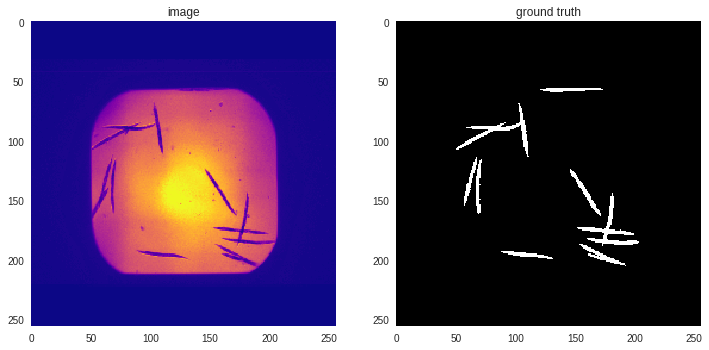

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

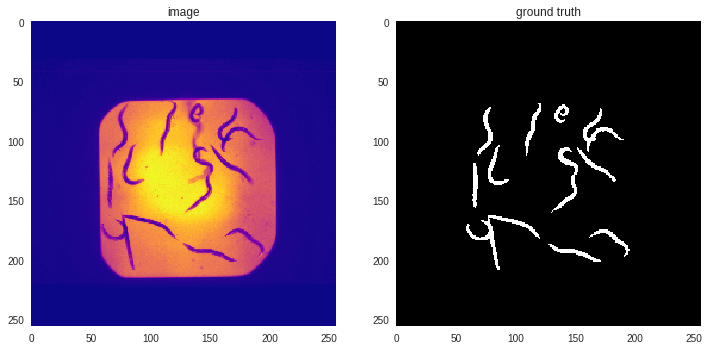

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

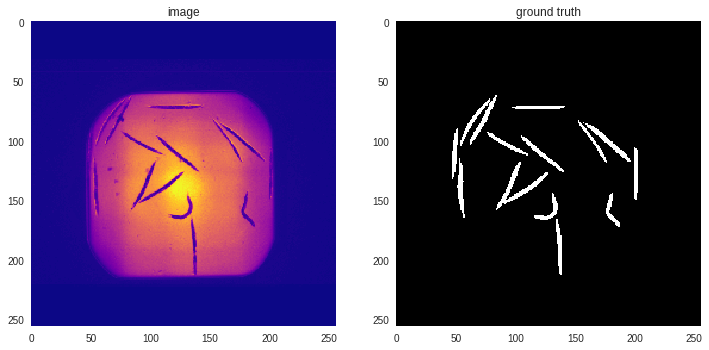

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

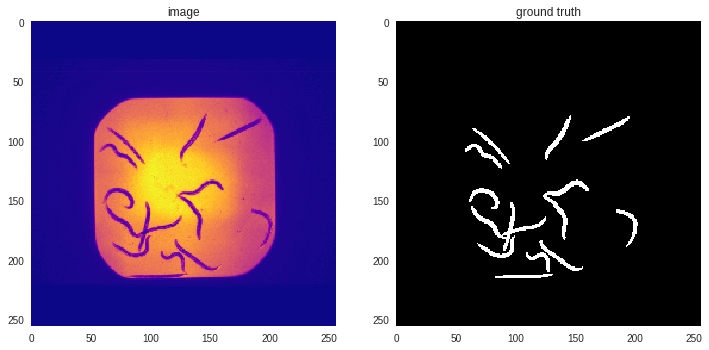

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

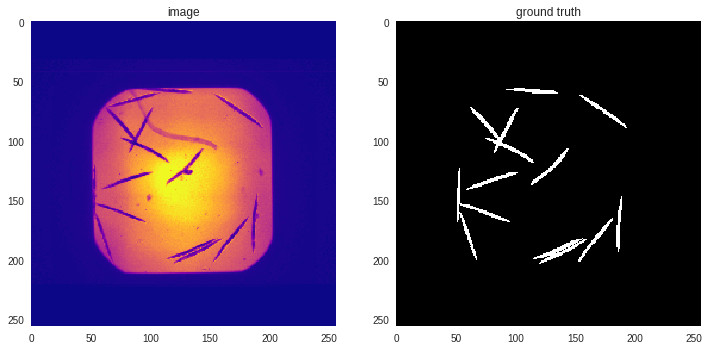

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

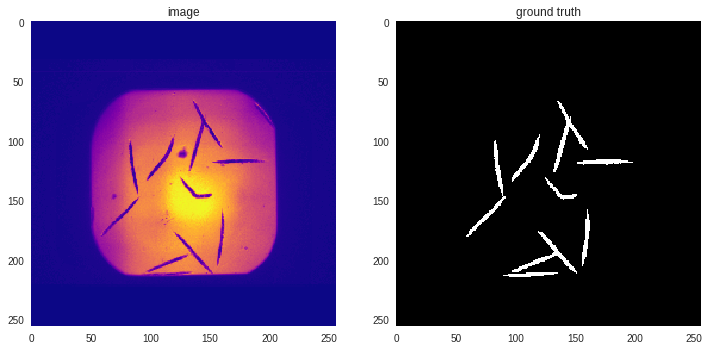

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

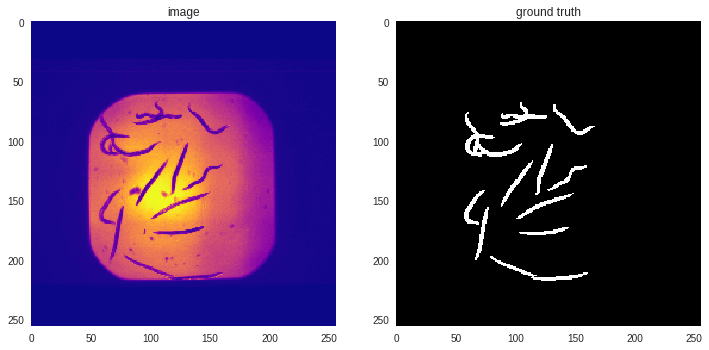

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

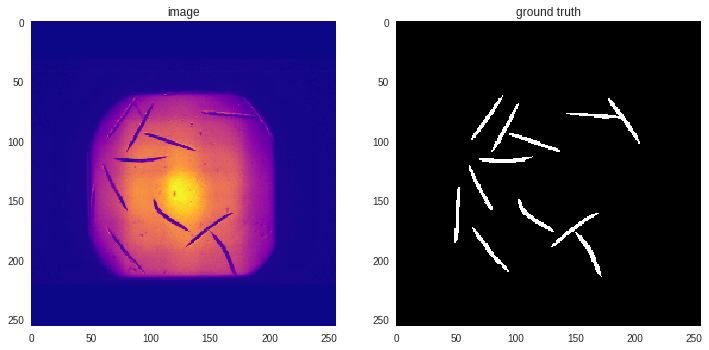

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

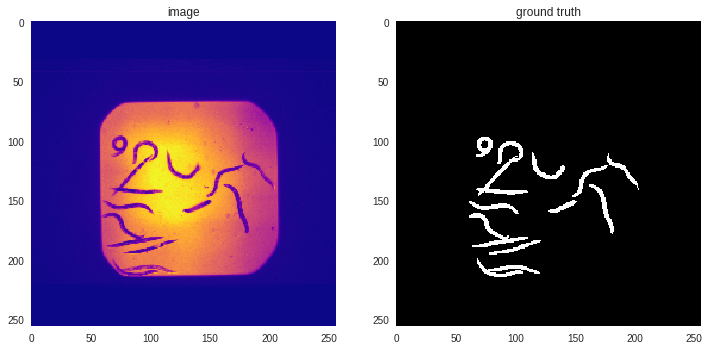

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

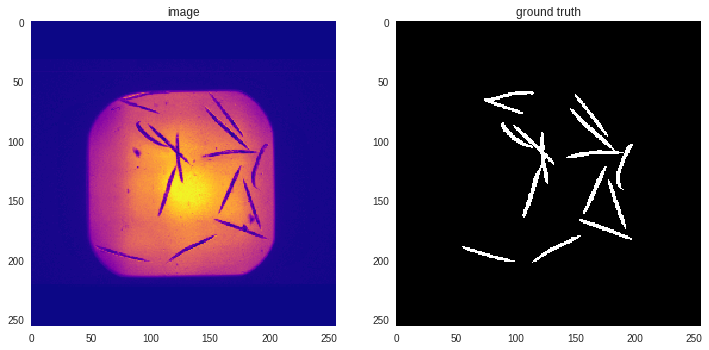

<IPython.core.display.Javascript object>

In [3]:
from google.colab import widgets

def plot(x, y, p=None, n=10):
    tb = widgets.TabBar([str(i) for i in range(len(x))][:n], location='top')
    for i in range(len(x))[:n]:
        image = x[i][...,0]
        truth = y[i][...,0]
        if p is not None: prediction = p[i] == 0
        with tb.output_to(i):
            if p is not None: fig, axs = plt.subplots(1,3)
            else:             fig, axs = plt.subplots(1,2)
            axs[0].imshow(image, cmap='plasma', vmin=0, vmax=1)
            axs[0].set_title('image')
            axs[1].imshow(truth)
            axs[1].set_title('ground truth')
            if p is not None:
                axs[2].imshow(prediction)
                axs[2].set_title('prediction')
            for ax in axs:
                ax.grid(False)

plot(X_train, Y_train)

# Define Network Topology

In [0]:
import keras
from keras.layers import Input, Conv2D, concatenate, AveragePooling2D
from keras.layers import UpSampling2D, BatchNormalization

channels_per_level = [32, 64, 128, 256]
bridge_channels = channels_per_level.pop()
identities = []
input_tensor = Input(shape=target_shape + (1,))
net = input_tensor

# encoder
for channels in channels_per_level:
    net = BatchNormalization(momentum=0.9)(net)
    net = Conv2D(channels, 3, padding='same', activation='relu')(net)
    identities.append(net)
    net = AveragePooling2D(padding='same')(net)

# bridge
net = BatchNormalization(momentum=0.9)(net)
net = Conv2D(bridge_channels, 3, padding='same', activation='relu')(net)

# decoder
for channels in channels_per_level[::-1]:
    net = UpSampling2D()(net)
    net = concatenate([net, identities.pop()])
    net = BatchNormalization(momentum=0.9)(net)
    net = Conv2D(channels, 3, padding='same', activation='relu')(net)

# classification
n_classes = Y_train[0].shape[-1]
net = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(net)

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Creating the Model

In [0]:
import keras.backend as K
from keras.models import Model

#https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


learning_rate = 1e-3
model = Model(input_tensor, net)
model.compile(loss=dice_coef_loss,
              metrics=[dice_coef],
              optimizer=keras.optimizers.Adam(lr=learning_rate))

# Train the Model

In [6]:
model.fit(X_train, Y_train, 
          validation_data=[X_val, Y_val],
          epochs=1, batch_size=1)

Train on 87 samples, validate on 10 samples
Epoch 1/1
87/87 [==============================] - 9s 105ms/step - loss: -0.9703 - dice_coef: 0.9703 - val_loss: -0.9926 - val_dice_coef: 0.9926


# Predicting Segmentations

In [7]:
predictions = []
for i in trange(len(X_val)):
    im = X_val[i]
    im = im.reshape((1,)+im.shape)
    prediction = model.predict(im)[0]
    prediction = np.argmax(prediction, axis=-1)
    predictions.append(prediction)
predictions = np.array(predictions)

100%|██████████| 10/10 [00:00<00:00, 22.02it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

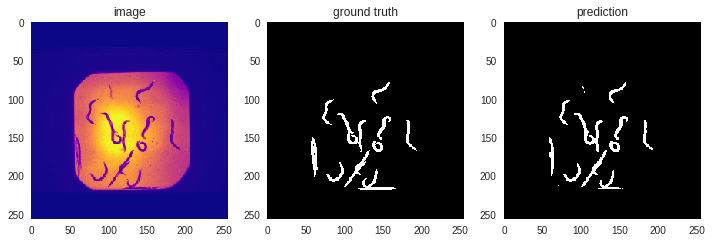

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

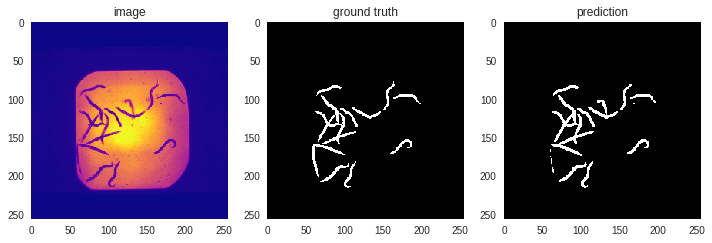

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

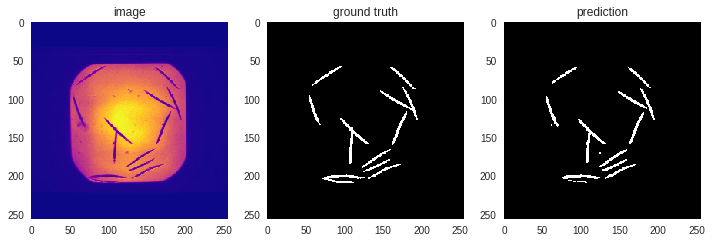

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

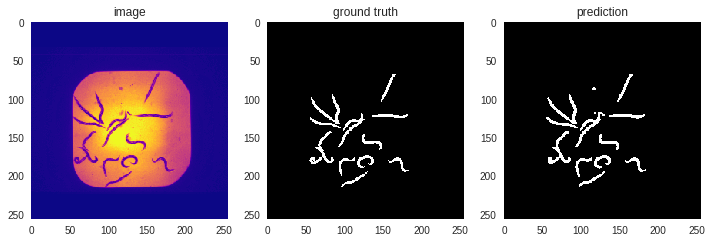

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

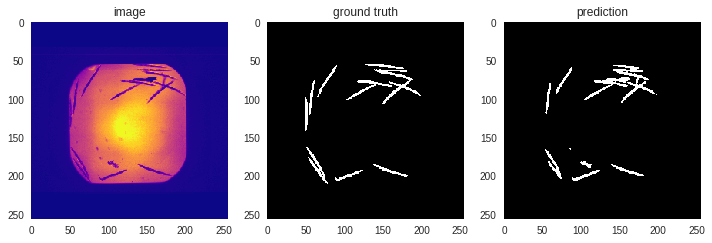

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

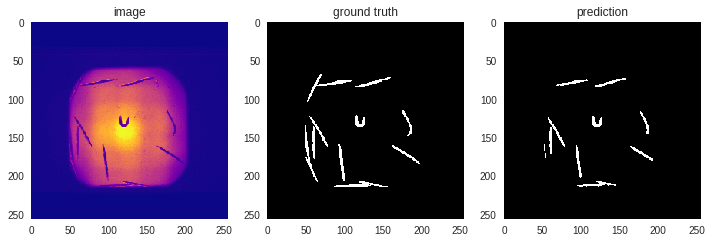

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

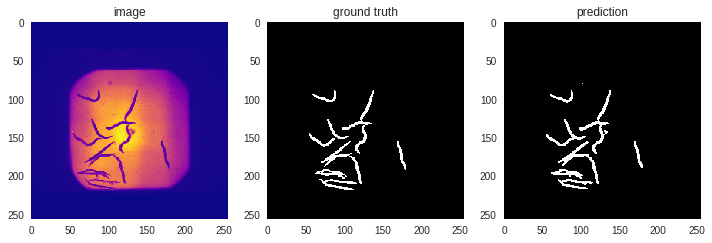

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

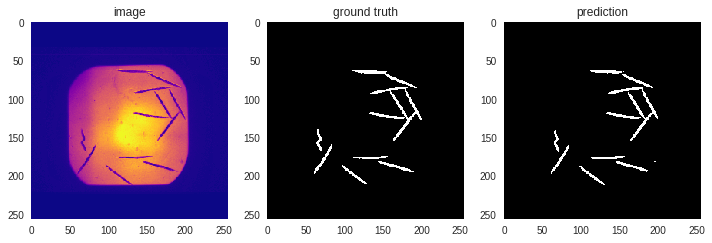

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

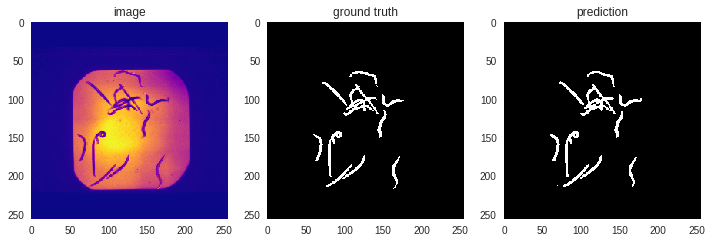

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

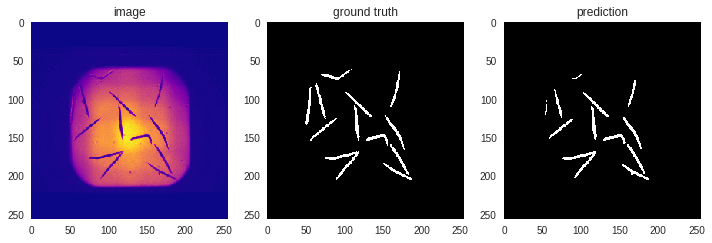

<IPython.core.display.Javascript object>

In [8]:
plot(X_val, Y_val, predictions)

## Data Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

augmentation = dict(rotation_range=10.,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.3,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect')

seed = 42
batch_size = 1
X_datagen = ImageDataGenerator(**augmentation)
Y_datagen = ImageDataGenerator(**augmentation)
X_datagen.fit(X_train, augment=True, seed=seed)
Y_datagen.fit(Y_train, augment=True, seed=seed)

X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:957: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (87, 256, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (87, 256, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [10]:
model.fit_generator(zip(X_train_augmented, Y_train_augmented),
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_data=[X_val, Y_val],)

Epoch 1/20
100/100 [==============================] - 7s 72ms/step - loss: -0.9883 - dice_coef: 0.9883 - val_loss: -0.9911 - val_dice_coef: 0.9911
Epoch 2/20
100/100 [==============================] - 7s 71ms/step - loss: -0.9899 - dice_coef: 0.9899 - val_loss: -0.9925 - val_dice_coef: 0.9925
Epoch 3/20
100/100 [==============================] - 7s 72ms/step - loss: -0.9896 - dice_coef: 0.9896 - val_loss: -0.9918 - val_dice_coef: 0.9918
Epoch 4/20
100/100 [==============================] - 7s 72ms/step - loss: -0.9895 - dice_coef: 0.9895 - val_loss: -0.9927 - val_dice_coef: 0.9927
Epoch 5/20
100/100 [==============================] - 7s 72ms/step - loss: -0.9890 - dice_coef: 0.9890 - val_loss: -0.9922 - val_dice_coef: 0.9922
Epoch 6/20
100/100 [==============================] - 7s 72ms/step - loss: -0.9895 - dice_coef: 0.9895 - val_loss: -0.9926 - val_dice_coef: 0.9926
Epoch 7/20
100/100 [==============================] - 7s 72ms/step - loss: -0.9899 - dice_coef: 0.9899 - val_loss: -0.

# HANDS ON: Tune the Hyperparameters

First:  
Examine the reproducibility of the results. Does the neural network always deliver the same performance?

Second:  
Try to tune different hyperparameters: 
  - How does the input shape of the images impact training performance?
  - Does a deeper architecture yield better results?
  - How about a wider architecture?
  - Do more conv layers per down-/upsample step change the result?